# Ematools demo

This notebook illustrates usage of `ematools` for exploring and preprocessing NDI EMA data.

In [29]:
import os
import numpy as np
from ematools import NDIData, coords2df, rotation_ref_creator  # pip install git+https://github.com/rsprouse/ematools
from phonlab.third_party.robustsmoothing import smoothn  # pip install git+https://github.com/rsprouse/phonlab
import matplotlib.pyplot as plt
%matplotlib inline

datadir = "../data"

def sensor_plot(coords, allsensors):
    '''Quick and dirty plotting for these acquisitions.'''
    colormap = [
        ('REF', 'b'), ('RMA', 'g'), ('LMA', 'orange'), ('JAW', 'r'),
        ('UL', 'y'), ('LL', 'y'), ('JW', 'r'), ('TT', 'k'), ('TB', 'k'), ('TD', 'k'),
        ('PL', 'b')
    ]
    for sensor, color in colormap:
        try:
            sidx = np.where(np.array(allsensors) == sensor)[0][0] # sensor index
            plt.plot(coords[:,sidx,0], coords[:,sidx,1], color=color)
        except IndexError:
            pass

## Explore a .tsv file

Load data in a .tsv file into an `NDIData` object. If you don't know the sensor names and locations yet, the sensor columns will automatically be prefixed with `Sn_`, where `n` is an index starting with 0.

In [2]:
dfile = os.path.join(datadir, 'human_test_with_6dref_000.tsv')
drec = NDIData(dfile)

Access the dataframe with the `df` attribute.

In [3]:
drec.df.head()

,sec,S0_id,S0_frame,S0_state,S0_q0,S0_qx,S0_qy,S0_qz,S0_x,S0_y,...,S14_id,S14_frame,S14_state,S14_q0,S14_qx,S14_qy,S14_qz,S14_x,S14_y,S14_z
0,0.004996,B5-03859-P01-CH0,756068,Signal too small,NaN,NaN,NaN,NaN,NaN,NaN,...,B5-03858-P04-CH1,756080,Bad Fit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.009992,B5-03859-P01-CH0,756072,Signal too small,NaN,NaN,NaN,NaN,NaN,NaN,...,B5-03858-P04-CH1,756084,Bad Fit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.014988,B5-03859-P01-CH0,756076,Signal too small,NaN,NaN,NaN,NaN,NaN,NaN,...,B5-03858-P04-CH1,756088,Bad Fit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.019984,B5-03859-P01-CH0,756080,Signal too small,NaN,NaN,NaN,NaN,NaN,NaN,...,B5-03858-P04-CH1,756092,Bad Fit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.024981,B5-03859-P01-CH0,756084,Signal too small,NaN,NaN,NaN,NaN,NaN,NaN,...,B5-03858-P04-CH1,756096,Processing Error,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Other attributes are available for inspection:

In [4]:
print(drec.rate)           # sample rate
print(drec.num_sensors)    # number of sensors loaded
print(drec.sensors)        # names of sensors, in order as they appear in dataframe
print(drec.state_cols)     # names of <sensor>_state columns

200.15558093305927
15
['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14']
['S0_state', 'S1_state', 'S2_state', 'S3_state', 'S4_state', 'S5_state', 'S6_state', 'S7_state', 'S8_state', 'S9_state', 'S10_state', 'S11_state', 'S12_state', 'S13_state', 'S14_state']


## Checking sensor states

There are multiple ways to explore the data columns for goodness of the data.

The `state_cols` attribute contains a list of the `<sensor>_state` columns. These contain comments on sensor observations. You can access these columns and use the Pandas [`describe()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) method to find the ones in which the most frequent observations are `OK` and there is a high proportion of `freq` compared to `count`.

In [5]:
drec.df[drec.state_cols].describe()

,S0_state,S1_state,S2_state,S3_state,S4_state,S5_state,S6_state,S7_state,S8_state,S9_state,S10_state,S11_state,S12_state,S13_state,S14_state
count,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001
unique,3,3,1,1,2,1,1,1,1,3,2,3,1,2,2
top,Signal too small,Signal too small,Tool Missing,OK,Processing Error,OK,Tool Missing,Tool Missing,OK,OK,Processing Error,Signal too small,OK,Bad Fit,Processing Error
freq,1937,1834,2001,2001,1522,2001,2001,2001,2001,1980,1911,1878,2001,1085,1094


The sensors at indexes [3, 5, 8, 9, 12] appear to contain meaningful data.

If you prefer you can look at data values directly to find `NaN` or other values that are likely to indicate good or bad data.

In [6]:
print(drec.df.S0_x.head())
print(drec.df.S3_x.head())

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: S0_x, dtype: float64
0   -0.155
1   -0.575
2   -0.111
3   -0.365
4   -0.202
Name: S3_x, dtype: float64


## Load a mix of known and unknown sensor data

When you know the mapping of sensors to columns, create a dictionary that maps known sensor names to index values. (Or provide a list of sensor names, using `None` as a placeholder for unknown sensors.) Use this mapping when you load the .tsv file and include the `load_all` parameter to indicate that unknown sensor values should also be loaded. The unknown sensors are prefixed with `Sn` as before.

In [7]:
sensordict = {'REF': 3, 'JAW': 5, 'LMA': 8, 'RMA': 9, 'OS': 12}
sensorlist = [None, None, None, 'REF', None, 'JAW', None, None, 'LMA', 'RMA', None, None, 'OS']
drec = NDIData(dfile, sensordict, load_all=True)
drec.df.head()

,sec,S0_id,S0_frame,S0_state,S0_q0,S0_qx,S0_qy,S0_qz,S0_x,S0_y,...,S14_id,S14_frame,S14_state,S14_q0,S14_qx,S14_qy,S14_qz,S14_x,S14_y,S14_z
0,0.004996,B5-03859-P01-CH0,756068,Signal too small,NaN,NaN,NaN,NaN,NaN,NaN,...,B5-03858-P04-CH1,756080,Bad Fit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.009992,B5-03859-P01-CH0,756072,Signal too small,NaN,NaN,NaN,NaN,NaN,NaN,...,B5-03858-P04-CH1,756084,Bad Fit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.014988,B5-03859-P01-CH0,756076,Signal too small,NaN,NaN,NaN,NaN,NaN,NaN,...,B5-03858-P04-CH1,756088,Bad Fit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.019984,B5-03859-P01-CH0,756080,Signal too small,NaN,NaN,NaN,NaN,NaN,NaN,...,B5-03858-P04-CH1,756092,Bad Fit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.024981,B5-03859-P01-CH0,756084,Signal too small,NaN,NaN,NaN,NaN,NaN,NaN,...,B5-03858-P04-CH1,756096,Processing Error,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Examining the `state_cols` shows the dataframe now holds meaningful values for the known sensors, and the unknown sensors (prefixed with `Sn`) do not appear to contain anything meaningful.

In [8]:
drec.df[drec.state_cols].describe()

,S0_state,S1_state,S2_state,REF_state,S4_state,JAW_state,S6_state,S7_state,LMA_state,RMA_state,S10_state,S11_state,OS_state,S13_state,S14_state
count,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001
unique,3,3,1,1,2,1,1,1,1,3,2,3,1,2,2
top,Signal too small,Signal too small,Tool Missing,OK,Processing Error,OK,Tool Missing,Tool Missing,OK,OK,Processing Error,Signal too small,OK,Bad Fit,Processing Error
freq,1937,1834,2001,2001,1522,2001,2001,2001,2001,1980,1911,1878,2001,1085,1094


## Load only known sensor data

When you are satisifed with the mapping of known sensors you can skip the loading of other sensor columns. Omit the `load_all` parameter (or set it to `False`) to load only known sensors provided by your sensor map.

In [9]:
drec = NDIData(dfile, sensordict)
drec.df[drec.state_cols].describe()

,REF_state,JAW_state,LMA_state,RMA_state,OS_state
count,2001,2001,2001,2001,2001
unique,1,1,1,3,1
top,OK,OK,OK,OK,OK
freq,2001,2001,2001,1980,2001


## Extract coordinates

Retrieve coordinate values with the `coords()` method. The values returned are a 3D ndarray in which the first axis is time in seconds, the second axis maps the sensors, and the third axis contains the `x`, `y`, `z` values.

The `coords()` method returns a tuple containing:
1. The coordinate  ndarray.
1. The time labels for the first dimension of the returned values.
1. The sensor labels for the second dimension of the returned values.

By default values for all times and all sensors are returned.

In [10]:
coords, tlabels, slabels = drec.coords()
assert(
    coords.shape == (
        len(tlabels),
        len(slabels),
        len(['x', 'y', 'z'])
    )
)
coords.shape

(2001, 5, 3)

Below is a plot of all the sensors for a single acquisition frame. Only the `x` (0) and `y` (1) dimensions are plotted.

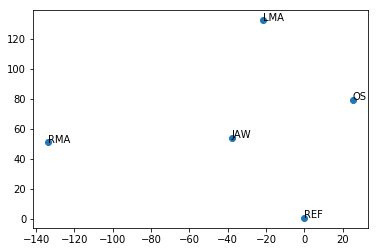

In [11]:
frame = 0
x = coords[frame,:,0]
y = coords[frame,:,1]
fig, ax = plt.subplots()
ax.scatter(x, y)
for n, txt in enumerate(slabels):
    ax.annotate(txt, (x[n], y[n]))

You can retrieve a subset of data values by specifying a `start` and `end` time for retrieval. You can also specify a subset of sensors with the `sensors` parameter.

In [12]:
coords, tlabels, slabels = drec.coords(start=0.02, end=0.04, sensors=['RMA', 'LMA'])
print(coords.shape)
print(tlabels)
print(slabels)
print(coords)

(4, 2, 3)
4    0.024981
5    0.029977
6    0.034973
7    0.039969
Name: sec, dtype: float64
['RMA', 'LMA']
[[[-133.622   51.254  -56.036]
  [ -21.821  132.776  -71.672]]

 [[-133.708   51.66   -55.522]
  [ -22.046  133.54   -71.078]]

 [[-133.537   51.35   -56.04 ]
  [ -22.179  133.243  -72.095]]

 [[-133.535   51.71   -55.548]
  [ -21.904  133.362  -70.99 ]]]


## Rotate coordinates with a `RotationRef` object

A `RotationRef` object is a special kind of `NDIData` object that can be used to  transform a set of coordinates into a reference space. There are two subtypes, `WaxBiteplate3Point` and `WaxBiteplateReferenced`. Both subtypes may have coordinate values from a 6DOF sensor; they differ in that the `WaxBiteplateReferenced` subtype's coordinates are relative to the 6DOF global reference sensor whereas the `WaxBiteplate3Point`'s coordinates are not.

If there is no 6DOF sensor in a recording there can be no global reference sensor. If there is a 6DOF sensor, then it can be selected as a 'Global Reference' in the acquisition software at the time of recording, and the output data will be either the `3Point` or `Referenced` subtype depending on your selection.

### `WaxBiteplate3Point`

A `WaxBiteplate3Point` recording does not have a global reference and will contain sensors at these locations: nasion, origin, molar, right_mastoid, left_mastoid. By default the sensor names for these are 'REF', 'OS', 'MS', 'RMA', 'LMA', respectively, and these names should be included in the sensor mapping you provide when you instantiate the object. The nasion and two mastoid sensors will also be present in non-biteplate recordings, and the mapping between these fixed points is used to calculate rotation and translation on a frame-by-frame basis.

The `rotation_ref_creator()` function chooses the right kind of `RotationRef` object automatically based on the sensors you declare in your sensor mapping. The mapping must contain ['REF', 'RMA', 'LMA'] sensors for `WaxBiteplate3Point` objects or none of those sensors for `WaxBiteplateReferenced` objects.

In [13]:
bp_sensors = [None, None, None, 'REF', 'MS', 'JAW', None, None, 'LMA', 'RMA', 'OS']
bpfile = os.path.join(datadir, 'human_test_without_6dref_biteplate_002.tsv')
bprec = rotation_ref_creator(bpfile, bp_sensors)
bprec

### Get raw coordinates

The first step in rotating coordinates is to get the raw coordinates from an acquisition.

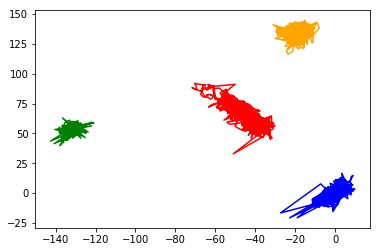

In [14]:
rawd, tlabels, slabels = drec.coords()
sensor_plot(rawd, slabels)

### Apply smoothing

If desired, apply a smoothing function to the coordinates.

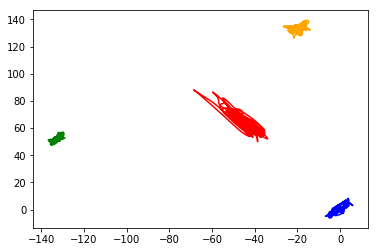

In [15]:
srawd = smoothn(rawd, axis=[0], isrobust=True, s=20.0)[0]
sensor_plot(srawd, slabels)

### Rotate the smoothed coordinates

The `WaxBiteplate3Point` object's `transform()` method rotates and translates an ndarray of coordinates. The first parameter passes the ndarray of coordinates. The second parameter provides a list of sensor labels in the order they appear in the second dimension of the coordinate ndarray. This list must include the same labels used to identify the nasion, right mastoid, and left mastoid sensors in the `WaxBiteplate3Point` object. By default these are the fixed sensors 'REF', 'RMA', and 'LMA'.

An idealized head location is determined for the fixed sensors in the biteplate recording, and then the same sensors in the input coordinate data are mapped frame-by-frame to the idealized locations. The rotation and translation required to perform this mapping is then applied to all the coordinate data to complete the `transform()`.

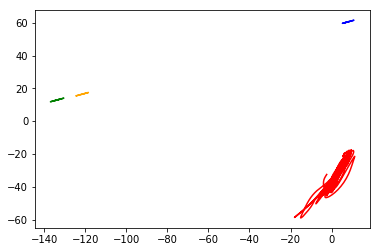

In [16]:
rotd = bprec.transform(srawd, slabels)
sensor_plot(rotd, drec.sensors)

## Rotate coordinates with a `WaxBiteplateReferenced` object

A `WaxBiteplateReferenced` object is similar to the `WaxBiteplate3Point` object, but has a reference sensor that provides global positioning for all the other sensor values. Transforming 6DOF data is simpler than 5DOF because it is not necessary to calculate a mapping of fixed sensors on a frame-by-frame basis. The same rotation and translation required to put the biteplate recording into reference orientation can simply be applied to all coordinates in related recordings with identical reference sensor placement. 

A `Referenced` wax biteplate recording should contain sensors at these locations: origin, molar. By default the sensor names for these are 'OS', 'MS', respectively, and these names should be included in the sensor mapping you provide when you instantiate the object. The 'REF' (nasion) reference sensor should not be included in the sensor mapping as it is in a different coordinate space than the other sensors.

In [17]:
bp_sensors_sn715 = {'OS': 11,'MS': 12}
refbpfile = os.path.join(datadir, 'SN715_BitePlate.tsv')
bpref = rotation_ref_creator(refbpfile, bp_sensors_sn715)
bpref

### Get raw coordinates

In [18]:
data_sensors_sn715 = {'UL': 1, 'LL': 2, 'JW': 3, 'TT': 4, 'TB': 5, 'TD': 6, 'PL': 13}
reftsvfile = os.path.join(datadir, 'SN715_MOCHA_TIMIT_451.tsv')
refrec = NDIData(reftsvfile, data_sensors_sn715)

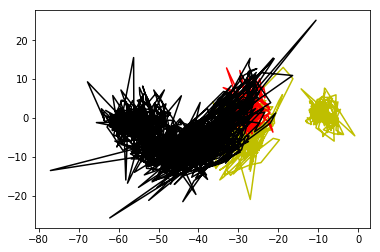

In [19]:
rawref, reftlabels, refslabels = refrec.coords()
sensor_plot(rawref, refslabels)

### Apply smoothing

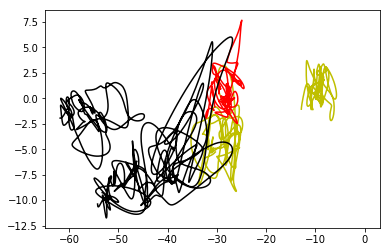

In [31]:
srawref = smoothn(rawref, axis=[0], isrobust=True, s=20.0)[0]
sensor_plot(srawref, refslabels)

### Rotate the smoothed coordinates

Note that `transform()` for a 6DOF rotation reference does not include a parameter for passing sensor labels. This is because it is not necessary to find and map fixed sensors to the rotation reference. All sensors are simply transformed using the same rotation and translation required to put the biteplate recording into the reference orientation.

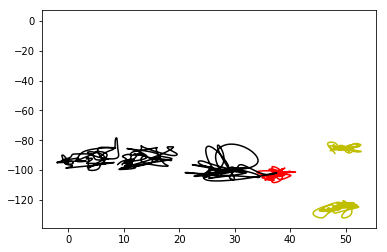

In [32]:
rotref = bpref.transform(srawref)
sensor_plot(rotref, refslabels)

## Convert coordinates to a dataframe

The `coords2df()` function flattens a 3D ndarray of coordinates into a dataframe table. The `sec` parameter provides the time column, and the `sensors` parameter is used to construct the `<sensor>_<xyz>` column names. Here we create a new dataframe from smoothed and rotated coordinates.

In [22]:
df = coords2df(rotref, sec=reftlabels, sensors=refslabels)
df.head()

,sec,UL_x,UL_y,UL_z,LL_x,LL_y,LL_z,JW_x,JW_y,JW_z,...,TT_z,TB_x,TB_y,TB_z,TD_x,TD_y,TD_z,PL_x,PL_y,PL_z
0,0.004994,48.063512,-88.840534,-101.420618,48.074026,-126.504131,-107.649588,36.078651,-103.695824,-104.490108,...,-114.168394,8.899887,-96.340820,-119.554468,-1.915584,-95.003490,-113.129350,19.130311,0.50889,-101.788133
1,0.004996,48.062260,-88.841595,-101.399317,48.046678,-126.513055,-107.674565,36.073734,-103.699635,-104.487504,...,-114.181523,8.902681,-96.337846,-119.567032,-1.906805,-94.994427,-113.127135,19.130311,0.50889,-101.788133
2,0.009992,48.058669,-88.841189,-101.357015,47.992129,-126.529457,-107.721391,36.063880,-103.705985,-104.482190,...,-114.206274,8.907322,-96.330920,-119.592784,-1.889254,-94.975067,-113.122317,19.130311,0.50889,-101.788133
3,0.014988,48.054964,-88.837351,-101.294658,47.914622,-126.549533,-107.785145,36.048787,-103.712826,-104.470940,...,-114.232172,8.912913,-96.317083,-119.627037,-1.863415,-94.946360,-113.114313,19.130311,0.50889,-101.788133
4,0.019984,48.048784,-88.825192,-101.212163,47.813740,-126.568883,-107.860249,36.027607,-103.716343,-104.450475,...,-114.257748,8.918653,-96.294264,-119.668088,-1.828640,-94.906463,-113.100500,19.130311,0.50889,-101.788133


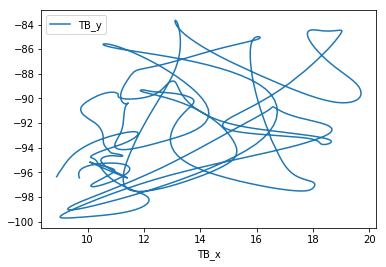

In [23]:
df.plot('TB_x', 'TB_y')  # Should match the previous plot of TB

### Save the smoothed and rotated data to a file

Once the coordinates have been converted to a dataframe, use [`to_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) to save the data to a file.

In [24]:
df.to_csv('somefile.tsv', sep='\t', index=False)

## A simple preprocessing function

It is useful to preprocess your raw EMA data by applying smoothing to the raw coordinates and transforming them into reference orientation. The following simple function does this preprocessing and saves to an output file that is much smaller than the raw data file.

In [25]:
def smooth_rotate_and_save_file(tsv, sensors, rotation_ref, out):
    '''
    Load raw NDI data from .tsv file, applying smoothing, then transform
    coordinates into a reference orientation, and save results to
    an output .tsv file.
    
    Parameters
    ----------
    tsv : str
        The path to the input .tsv file to be processed.
        
    sensors : list or dict
        The mapping of sensor names to sensor index for the input .tsv file.
        
    rotation_ref : a `RotationRef` object, e.g. `WaxBiteplate[56]D`
        The object with the reference orientation and that implements the
        `transform()` method.
        
    out : str
        The output .tsv filename.
        
    Returns
    -------
    No return value. Errors thrown during the processing will raise to the
    caller.
    '''
    rec = NDIData(tsv, sensors)
    rawd, tlabels, slabels = rec.coords()
    srawd = smoothn(rawd, axis=[0], isrobust=True, s=20.0)[0]
    if rotation_ref.has_global_ref:
        rotd = rotation_ref.transform(srawd)
    else:
        rotd = rotation_ref.transform(srawd, slabels)
    df = coords2df(rotd, sec=tlabels, sensors=slabels)
    df.to_csv(out, sep='\t', index=False)

Example usage:

In [26]:
# The biteplate recording that provides the reference orientation
bp_sensors = [None, None, None, 'REF', 'MS', 'JAW', None, None, 'LMA', 'RMA', 'OS']
bpfile = os.path.join(datadir, 'human_test_without_6dref_biteplate_002.tsv')
bprec = rotation_ref_creator(bpfile, bp_sensors)

# The .tsv file to preprocess
tsvname = os.path.join(datadir, 'human_test_with_6dref_000.tsv')
sensordict = {'REF': 3, 'JAW': 5, 'LMA': 8, 'RMA': 9, 'OS': 12}

# Preprocess and save
smooth_rotate_and_save_file(
    tsv=tsvname,
    sensors=sensordict,
    rotation_ref=bprec,
    out='rotatedfile.tsv'
)